In [1]:
import sys
sys.path.append("..")
import pickle as pkl
import numpy as np
import pandas
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import networkx as nx
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from coh_tools import map_to_ecog

In [2]:
os.chdir("../../opto_data_analysis/pickled")
os.listdir()
locations = pkl.load(open("electrode_positions.pkl", "rb"))
os.chdir("../csvs")
ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = "./")


In [3]:
os.listdir('..')

['.DS_Store',
 '.git',
 '.ipynb_checkpoints',
 'coh_tools.py',
 'conn_metric_compare',
 'control_analysis',
 'csvs',
 'dmd',
 'figures',
 'get_5sec_data.py',
 'get_data.py',
 'get_electrode_locations.ipynb',
 'matlab',
 'old_notebooks',
 'PCA_feature_evolution',
 'pickled',
 'picklers',
 'plotting',
 'plot_coh',
 'processed_data_info.docx',
 'README.md',
 'stdp_analysis',
 'timefreq_analysis',
 '__pycache__']

In [4]:
# Get experiment info
# os.chdir("../../../lab/opto_data_analysis/csvs")
# os.chdir(r"C:\Users\julienb\lab\oe_data_analysis\csvs")
experiments = pandas.read_csv('table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]

M1_sites = pandas.read_csv('get_sessions.csv')

In [5]:
experiments

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0    Experiment1  MonkeyG  20150908  Session2     M1   
1    Experiment2  MonkeyG  20150908  Session3     M1   
2    Experiment3  MonkeyG  20150908  Session4     M1   
3    Experiment4  MonkeyG  20150909  Session2     M1   
4    Experiment5  MonkeyG  20150909  Session3     M1   
..           ...      ...       ...       ...    ...   
64  Experiment65  MonkeyJ  20160627  Session2     S1   
65  Experiment66  MonkeyJ  20160630  Session1     S1   
66  Experiment67  MonkeyJ  20160630  Session3     S1   
67  Experiment68  MonkeyJ  20160702  Session2     S1   
68  Experiment69  MonkeyJ  20160702  Session4     S1   

                           File Name  stim_Coh_from  stim_Coh_to  \
0   MonkeyG_20150908_Session2_M1.zip             46           63   
1   MonkeyG_20150908_Session3_M1.zip             48           43   
2   MonkeyG_20150908_Session4_M1.zip             48           16   
3   MonkeyG_20150909_Session2_M1.zip             48           12   
4   MonkeyG_20150909_Session3_M1.zip             53           27   
..                               ...            ...          ...   
64  MonkeyJ_20160627_Session2_S1.zip             39           14   
65  MonkeyJ_20160630_Session1_S1.zip             62           55   
66  MonkeyJ_20160630_Session3_S1.zip             58           63   
67  MonkeyJ_20160702_Session2_S1.zip             50           37   
68  MonkeyJ_20160702_Session4_S1.zip             44           64   

    Number of Lasers in Experiment  Number of Lasers during Conditioning  \
0                                2                                     2   
1                                2                                     2   
2                                2                                     2   
3                                2                                     2   
4                                2                                     2   
..                             ...                                   ...   
64                               2                                     2   
65                               2                                     2   
66                               2                                     2   
67                               2                                     2   
68                               2                                     2   

    Delay                       keyname   one   two  doubles  singles  
0    10ms  MonkeyG_20150908_Session2_M1  True  True     True    False  
1    10ms  MonkeyG_20150908_Session3_M1  True  True     True    False  
2    10ms  MonkeyG_20150908_Session4_M1  True  True     True    False  
3    10ms  MonkeyG_20150909_Session2_M1  True  True     True    False  
4    10ms  MonkeyG_20150909_Session3_M1  True  True     True    False  
..    ...                           ...   ...   ...      ...      ...  
64  100ms  MonkeyJ_20160627_Session2_S1  True  True     True    False  
65  100ms  MonkeyJ_20160630_Session1_S1  True  True     True    False  
66   10ms  MonkeyJ_20160630_Session3_S1  True  True     True    False  
67   10ms  MonkeyJ_20160702_Session2_S1  True  True     True    False  
68  100ms  MonkeyJ_20160702_Session4_S1  True  True     True    False  

[69 rows x 16 columns]

In [6]:
# os.chdir("../../../Desktop/GDrive/opto_data")
# os.chdir("../../data/opto_data")
os.chdir("D:\gdrive\opto_data")

In [7]:
data = pkl.load(open("20sec_processed_optodata_withshort_5aug20.pkl", "rb"))

In [13]:
for band in data.keys():
    data[band] = data[band].dropna()

In [14]:
# # Get only stim-site data
# local_data = {}
# for band in data.keys():
#     local_data[band] = data[band][(data[band]["Is_stim_site_1"] == 1) & (data[band]["Is_stim_site_2"] == 1)]

In [15]:
first_data = {}
# first_local_data = {}

for band in data.keys():
    first_data[band] = data[band][data[band]["Block_num"] == 1]
#     first_local_data[band] = local_data[band][local_data[band]["Block_num"] == 1]

In [16]:
# All data, whole-session changes
# All features

for band in data.keys():
    print(band)
    formula_all_wholesess = "End_diff ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further + \
    Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Graph_avg_net_coh + Coh_diff_mag"
    mod1 = ols(formula=formula_all_wholesess, data=first_data[band])
    res1 = mod1.fit()
    print(res1.rsquared)
    print(mean_squared_error(first_data[band]["cond_diff_Y"], res1.predict(first_data[band])))
    
    formula_protocol = "End_diff ~ Distance + Phase + Delays + Monkeys + Block_num + Both_M1 + Both_S1 + \
    Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further"
    mod_protocol = ols(formula=formula_protocol, data=first_data[band])
    res_protocol = mod_protocol.fit()
    print(res_protocol.rsquared)
    print(mean_squared_error(first_data[band]["cond_diff_Y"], res_protocol.predict(first_data[band])))


    formula_graph = "End_diff ~ Initial_coh + Pair_avg_net_coh  + Elec_cov + \
    Time_cov + Coh_proj + Graph_avg_net_coh + Coh_diff_mag"
    mod_graph = ols(formula=formula_graph, data=first_data[band])
    res_graph = mod_graph.fit()
    print(res_graph.rsquared)
    print(mean_squared_error(first_data[band]["cond_diff_Y"], res_graph.predict(first_data[band])))


theta
0.31266536189638716
0.010704101939073158
0.07049579617729751
0.011270871022125444
0.1284757470576645
0.01038836776179563
beta
0.16447118601148758
0.005082775580381063
0.05930041392535901
0.0057599001103885985
0.0938544653013128
0.0046637290456409295
gamma
0.2170109024197947
0.003821980366309247
0.034682245740356055
0.004139726336879038
0.1419320797113598
0.0036267788402821813
high_gamma
0.27717290209296497
0.0037494081601458394
0.024918990834991384
0.004386911990341641
0.20751956511981562
0.0036565484467836235


In [17]:
repr_r_sessions = []
repr_m_sessions = []
# Get r squareds of individual sessions
for session in first_data["high_gamma"]["Experiment_block_key"].unique():
    session_data = first_data["high_gamma"][first_data["high_gamma"]["Experiment_block_key"] == session]
    r2 = r2_score(session_data["End_diff"], res1.predict(session_data))
    if (.2 < r2):
        print(session)
        print(r2)
    
    
#     for block in range(1, 6):
#         session_block_data = session_data[session_data["Block_num"] == block]
#         block_r2 = r2_score(session_block_data["cond_diff_Y"], res1.predict(session_block_data))
#         if (.2 < block_r2):
#             print(session)

#             print(block)
#             print(block_r2)
#             if (block_r2 < .33):
#                 repr_r_sessions.append([[session, block]])
                
#         block_mse = mean_squared_error(session_block_data["cond_diff_Y"], res1.predict(session_block_data))

#         if (block_mse < .0025):
#             repr_m_sessions.append([[session, block]])

MonkeyG_20150911_Session7_S1
0.2577882370621897
MonkeyG_20150915_Session2_S1
0.5251484363933752
MonkeyG_20150915_Session3_S1
0.28724556698246106
MonkeyG_20150916_Session4_S1
0.21805289645948134
MonkeyG_20150925_Session1_S1
0.33440621022697614
MonkeyJ_20160627_Session2_S1
0.33456303284776423


In [18]:
len(repr_m_sessions)

0

In [19]:
repr_sessions

NameError: name 'repr_sessions' is not defined

In [ ]:
def get_M1_sites_from_experiment(session):
    subject = experiments[experiments["keyname"] == session]['Monkey'].values[0][-1]
    date = experiments[experiments["keyname"] == session]["YYYYMMDD"].values[0]
    sess = experiments[experiments["keyname"] == session]["Session"].values[0][-1]

    my_M1 = M1_sites[M1_sites['name'].str.startswith(subject)]
    my_M1 = my_M1[my_M1["date"] == date]
    my_M1 = my_M1[my_M1["session"] == int(sess)]

    return [int(e) for e in my_M1["M1_sites"].values[0].split(',')]

In [ ]:
# for session in ['MonkeyG_20150922_Session2_S1']:
#     print(session)

#     laser_from = int(experiments[experiments['keyname'] == session]["stim_Coh_from"])
#     laser_to = int(experiments[experiments['keyname'] == session]["stim_Coh_to"])
#     sess1=data["high_gamma"][data["high_gamma"]["Experiment_block_key"]==session][data["high_gamma"]["Block_num"]==5]

#     v_scale = .3
#     figs, axs = plt.subplots(2, 4, figsize=(15*4/3+2.5, 11*2/3-1))

#     sess1["prot_pred"] = res_protocol.predict(sess1)
#     sess1["graph_pred"] = res_graph.predict(sess1)
#     sess1["full_pred"] = res1.predict(sess1)

#     sess1_copy = sess1[sess1["Distance"] < 6]

#     # Build your graph
#     G=nx.from_pandas_edgelist(sess1_copy, 'From_electrodes', 'To_electrodes', ['prot_pred', 'graph_pred', 'full_pred', 'cond_diff_Y'])

#     M1 = get_M1_sites_from_experiment(session)
#     node_colors = []
#     for node in list(G.nodes):
#         if node in M1:
#             node_colors.append('darkgreen')
#         else:
#             node_colors.append('darkorange')
    
#     nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 3], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['cond_diff_Y'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[0, 3].set_title("Ground truth")
#     axs[0, 3].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     axs[0, 3].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 0], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['prot_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[0, 0].set_title("Protocol prediction")
#     axs[0, 0].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     axs[0, 0].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 1], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['graph_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[0, 1].set_title("Graph prediction")
#     axs[0, 1].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     axs[0, 1].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     nx.draw(G, with_labels=False, pos=locations, ax=axs[1, 0], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['cond_diff_Y']-nx.to_pandas_edgelist(G)['prot_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[1, 0].set_title("Protocol residual")
#     axs[1, 0].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     axs[1, 0].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     nx.draw(G, with_labels=False, pos=locations, ax=axs[1, 1], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['cond_diff_Y']-nx.to_pandas_edgelist(G)['graph_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[1, 1].set_title("Graph residual")
#     axs[1, 1].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     axs[1, 1].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 2], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['full_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[0, 2].set_title("Full model prediction")
#     axs[0, 2].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     axs[0, 2].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     nx.draw(G, with_labels=False, pos=locations, ax=axs[1, 2], node_color=node_colors, node_size=30,
#             edge_color=nx.to_pandas_edgelist(G)['cond_diff_Y']-nx.to_pandas_edgelist(G)['full_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
#     axs[1, 2].set_title("Full model residual")
#     f = axs[1, 2].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
#     t = axs[1, 2].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

#     c1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkgreen", ms=8)
#     c2 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkorange", ms=8)
#     axs[1, 3].legend([f, t, c1, c2],["Stim site 1", "Stim site 2", "In M1", "In S1"], prop={'size': 15})
#     axs[1,3].axis('off')

#     sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr, norm=plt.Normalize(vmin = -v_scale, vmax = v_scale))
#     sm._A = []
#     figs.colorbar(sm, ax=axs.ravel().tolist(), label="Whole session coherence change")

#     plt.show()
    
#     # figs.savefig("../../../Desktop/GDrive/GDocuments/Nature_biomed/figures/hgamma_MonkeyG_20150915_Session2_S1_preds_and_truths.pdf",bbox_inches='tight')
# #     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150916_Session4_S1_preds_and_res6.pdf",bbox_inches='tight')
# #     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150915_Session2_S1_preds_and_res6.pdf",bbox_inches='tight')

In [ ]:
repr_r_sessions

MonkeyG_20150915_Session2_S1


<ipython-input-20-14494c796adb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess1["prot_pred"] = res_protocol.predict(sess1)
<ipython-input-20-14494c796adb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess1["graph_pred"] = res_graph.predict(sess1)
<ipython-input-20-14494c796adb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

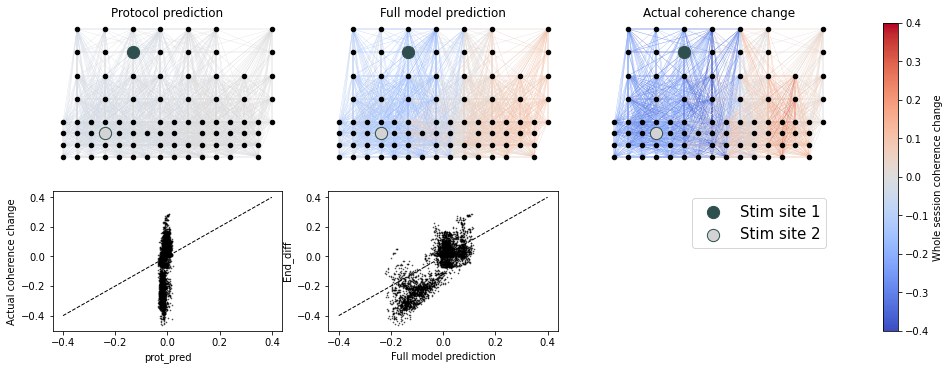

In [20]:
for session in ['MonkeyG_20150915_Session2_S1']:
    print(session)

    laser_from = int(experiments[experiments['keyname'] == session]["stim_Coh_from"])
    laser_to = int(experiments[experiments['keyname'] == session]["stim_Coh_to"])
    sess1=first_data["high_gamma"][first_data["high_gamma"]["Experiment_block_key"]==session]#[data["high_gamma"]["Block_num"]==5]

    v_scale = .4
    figs, axs = plt.subplots(2, 3, figsize=(15*3/3+2.5, 10*2/3-1))

    sess1["prot_pred"] = res_protocol.predict(sess1)
    sess1["graph_pred"] = res_graph.predict(sess1)
    sess1["full_pred"] = res1.predict(sess1)

    sess1_copy = sess1[sess1["Distance"] < 6]

    # Build your graph
    G=nx.from_pandas_edgelist(sess1_copy, 'From_electrodes', 'To_electrodes', ['prot_pred', 'graph_pred', 'full_pred', 'End_diff'])

    M1 = get_M1_sites_from_experiment(session)
    node_colors = []
    for node in list(G.nodes):
        if node in M1:
            node_colors.append('darkgreen')
        else:
            node_colors.append('darkorange')
    
    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 2], node_color='black', node_size=20,
            edge_color=nx.to_pandas_edgelist(G)['End_diff'], width=.3, edge_cmap=plt.cm.coolwarm, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 2].set_title("Actual coherence change")
    axs[0, 2].scatter(locations[laser_from][0], locations[laser_from][1], color="darkslategrey", zorder=3, s=150)
    axs[0, 2].scatter(locations[laser_to][0], locations[laser_to][1], color="lightgrey", edgecolor="darkslategrey", zorder=3, s=150)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 0], node_color='black', node_size=20,
            edge_color=nx.to_pandas_edgelist(G)['prot_pred'], width=.3, edge_cmap=plt.cm.coolwarm, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 0].set_title("Protocol prediction")
    axs[0, 0].scatter(locations[laser_from][0], locations[laser_from][1], color="darkslategrey", zorder=3, s=150)
    axs[0, 0].scatter(locations[laser_to][0], locations[laser_to][1], color="lightgrey", edgecolor="darkslategrey", zorder=3, s=150)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 1], node_color='black', node_size=20,
            edge_color=nx.to_pandas_edgelist(G)['full_pred'], width=.3, edge_cmap=plt.cm.coolwarm, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 1].set_title("Full model prediction")
    f = axs[0, 1].scatter(locations[laser_from][0], locations[laser_from][1], color="darkslategrey", zorder=3, s=150)
    t = axs[0, 1].scatter(locations[laser_to][0], locations[laser_to][1], color="lightgrey", edgecolor="darkslategrey", zorder=3, s=150)

    onep = sess1[(sess1["Is_stim_site_1"] == 1) & (sess1["Is_stim_site_2"] == 1)]

    axs[1, 0].set_xlabel("Protocol prediction")
    sns.scatterplot(x="prot_pred", y="End_diff", data=sess1, alpha=.5, color='black', s=1, legend="full", ax=axs[1, 0], edgecolor=None)
#     sns.scatterplot(x="prot_pred", y="End_diff", data=onep, color="lightblue", edgecolor="black", s=100, label="Stim site change", ax=axs[1, 0])
    axs[1, 0].plot(np.arange(-.4, .5, .1), np.arange(-.4, .5, .1), color="black", linestyle="dashed", linewidth=1)
    axs[1, 0].set_ylabel("Actual coherence change")

    axs[1, 1].plot(np.arange(-.4, .5, .1), np.arange(-.4, .5, .1), color="black", linestyle="dashed", linewidth=1)
    sns.scatterplot(x="full_pred", y="End_diff", data=sess1, alpha=.5, color='black', s=1, legend="full", ax=axs[1, 1], edgecolor=None)
#     sns.scatterplot(x="full_pred", y="End_diff", data=onep, color="lightblue", edgecolor="black", s=100, label="Stim site change", ax=axs[1, 1])
    axs[1, 1].set_xlabel("Full model prediction")
    
#     c1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkgreen", ms=8)
#     c2 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkorange", ms=8)
    axs[1, 2].legend([f, t],["Stim site 1", "Stim site 2"], prop={'size': 15})
    axs[1, 2].axis('off')

    norm = plt.Normalize(vmin = -v_scale, vmax = v_scale)
#     lognorm = SymLogNorm(.000001, vmin=-v_scale, vmax=v_scale)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    sm._A = []
    figs.colorbar(sm, ax=axs[0:2, 0:3], label="Whole session coherence change")

    plt.show()
    
#     figs.savefig("D:/gdrive/GDocuments/Nature_biomed/figures/presubfig_v2.pdf",bbox_inches='tight')
#     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150916_Session4_S1_preds_and_res6.pdf",bbox_inches='tight')
#     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150915_Session2_S1_preds_and_res6.pdf",bbox_inches='tight')

In [19]:
sess1["prot_pred"]

492941   -0.017431
492942   -0.019404
492943   -0.021565
492944   -0.016946
492945   -0.018999
            ...   
500246    0.004665
500247    0.002685
500333    0.006478
500334    0.004532
500421    0.008445
Name: prot_pred, Length: 3741, dtype: float64

In [24]:
r2_score(sess1["End_diff"], sess1["prot_pred"])

-0.05614950868291935

In [22]:
sess1

Initial_coh  Distance  Coh_proj  Coh_proj_sd     Phase  \
492941     0.441542  1.000000  0.146829     6.649298  0.002159   
492942     0.499800  2.000000  0.115291     6.092165  0.000368   
492943     0.444619  3.000000  0.149172     6.582181  0.005990   
492944     0.526226  1.000000  0.143915     7.267071  0.011158   
492945     0.451124  1.414214  0.157218     6.530427  0.003898   
...             ...       ...       ...          ...       ...   
500246     0.220939  3.000000  0.012761     0.062812  0.008343   
500247     0.237991  7.000000  0.013193     0.066090  0.003589   
500333     0.466780  2.000000  0.019835     0.091990  0.000926   
500334     0.482841  6.000000  0.020230     0.089433  0.006677   
500421     0.503623  4.000000  0.020012     0.078055  0.007105   

        From_electrodes  To_electrodes  Initial_coh_sd  Coh_diff_sd  \
492941                1              2        0.112254     0.023843   
492942                1              3        0.110711     0.016855   
492943                1              4        0.110561     0.026816   
492944                1              5        0.125639     0.007963   
492945                1              6        0.104781     0.034345   
...                 ...            ...             ...          ...   
500246               89             92        0.012712     0.002647   
500247               89             94        0.012365     0.002466   
500333               90             92        0.011291     0.002746   
500334               90             94        0.010460     0.003041   
500421               92             94        0.009629     0.000981   

        Pair_avg_net_coh  ...  Is_stim_site_1  Is_stim_site_2  \
492941          0.650705  ...               0               0   
492942          0.556364  ...               0               0   
492943          0.658579  ...               0               0   
492944          0.624575  ...               0               0   
492945          0.683468  ...               0               0   
...                  ...  ...             ...             ...   
500246          0.180345  ...               0               0   
500247          0.181733  ...               0               0   
500333          0.195272  ...               0               0   
500334          0.196660  ...               0               0   
500421          0.190156  ...               0               0   

        Las1_distance_to_closer  Las1_distance_to_further  \
492941                11.180340                 12.083046   
492942                10.295630                 12.083046   
492943                 9.433981                 12.083046   
492944                11.704700                 12.083046   
492945                10.770330                 12.083046   
...                         ...                       ...   
500246                12.806248                 14.866069   
500247                10.770330                 14.866069   
500333                12.806248                 14.142136   
500334                10.770330                 14.142136   
500421                10.770330                 12.806248   

        Las2_distance_to_closer  Las2_distance_to_further  Coh_diff_mag  \
492941                 3.605551                  4.242641      0.093108   
492942                 3.162278                  4.242641      0.036996   
492943                 3.000000                  4.242641      0.101548   
492944                 3.605551                  4.242641      0.057581   
492945                 2.828427                  4.242641      0.125116   
...                         ...                       ...           ...   
500246                12.000000                 12.369317      0.037363   
500247                12.369317                 12.649111      0.037681   
500333                12.000000                 12.165525      0.022799   
500334                12.165525                 12.649111      0.022865   
500421                1

In [126]:
f

Text(0.5, 0, 'Full model prediction')

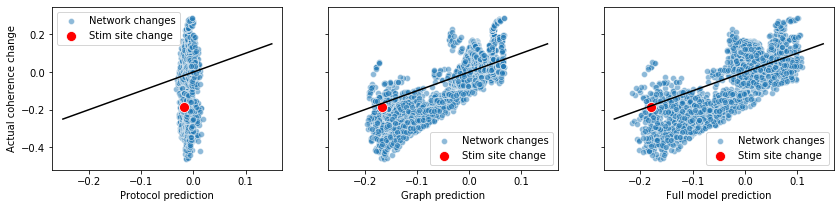

In [16]:
onep = sess1[(sess1["Is_stim_site_1"] == 1) & (sess1["Is_stim_site_2"] == 1)]

fig, axs = plt.subplots(1, 3, figsize=(14,3), sharey=True)

sns.scatterplot(x="prot_pred", y="End_diff", data=sess1, alpha=.5, legend="full", label="Network changes", ax=axs[0])
sns.scatterplot(x="prot_pred", y="End_diff", data=onep, color="red", s=100, label="Stim site change", ax=axs[0])
axs[0].plot(np.arange(-.25, .25, .1), np.arange(-.25, .25, .1), color="black")
axs[0].set_xlabel("Protocol prediction")
axs[0].set_ylabel("Actual coherence change")

sns.scatterplot(x="graph_pred", y="End_diff", data=sess1, alpha=.5, legend="full", label="Network changes", ax=axs[1])
sns.scatterplot(x="graph_pred", y="End_diff", data=onep, color="red", s=100, label="Stim site change", ax=axs[1])
axs[1].plot(np.arange(-.25, .25, .1), np.arange(-.25, .25, .1), color="black")
axs[1].set_xlabel("Graph prediction")

sns.scatterplot(x="full_pred", y="End_diff", data=sess1, alpha=.5, legend="full", label="Network changes", ax=axs[2])
sns.scatterplot(x="full_pred", y="End_diff", data=onep, color="red", s=100, label="Stim site change", ax=axs[2])
axs[2].plot(np.arange(-.25, .25, .1), np.arange(-.25, .25, .1), color="black")
axs[2].set_xlabel("Full model prediction")

# plt.xlabel("Predicted coherence change")
# plt.ylabel("Actual coherence change")
# plt.title("Whole session coherence changes for example high gamma session")
# plt.legend()

# plt.savefig("../../../Desktop/GDrive/GDocuments/Nature_biomed/figures/hgamma_MonkeyG_20150915_Session2_S1_scatter.pdf", bbox_inches='tight')
# plt.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150915_Session2_S1_scatters.pdf", bbox_inches='tight')
# plt.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150916_Session4_S1_scatters.pdf", bbox_inches='tight')


MonkeyG_20150915_Session2_S1


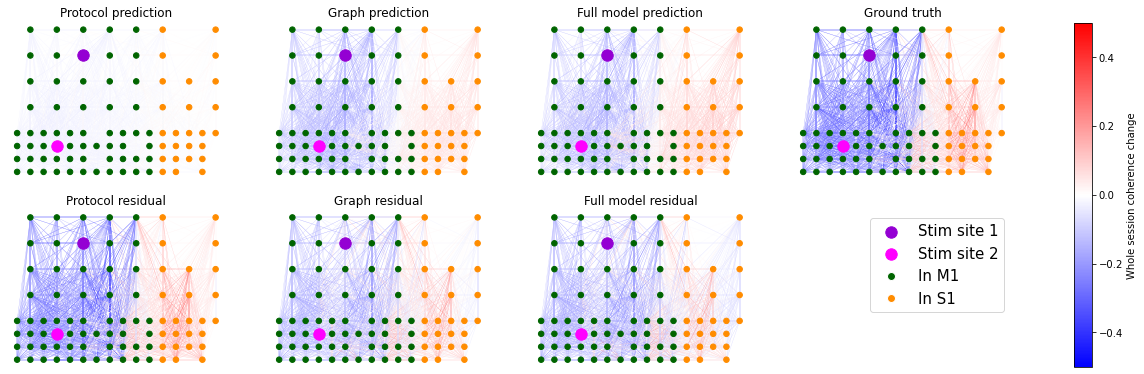

KeyboardInterrupt: 

In [27]:
for session in ['MonkeyG_20150915_Session2_S1']:#first_data["high_gamma"]["Experiment_block_key"].unique():
    print(session)

    laser_from = int(experiments[experiments['keyname'] == session]["stim_Coh_from"])
    laser_to = int(experiments[experiments['keyname'] == session]["stim_Coh_to"])
    sess1=first_data["high_gamma"][first_data["high_gamma"]["Experiment_block_key"]==session]
    
    sess1=sess1[sess1["Is_stim_site_1"] == True]
    
    v_scale = .5
    figs, axs = plt.subplots(2, 4, figsize=(15*4/3+2.5, 11*2/3-1))

    sess1["prot_pred"] = res_protocol.predict(sess1)
    sess1["graph_pred"] = res_graph.predict(sess1)
    sess1["full_pred"] = res1.predict(sess1)

#     sess1_copy = sess1[sess1["Distance"] < 6]

    # Build your graph
    G=nx.from_pandas_edgelist(sess1_copy, 'From_electrodes', 'To_electrodes', ['prot_pred', 'graph_pred', 'full_pred', 'End_diff'])

    M1 = get_M1_sites_from_experiment(session)
    node_colors = []
    for node in list(G.nodes):
        if node in M1:
            node_colors.append('darkgreen')
        else:
            node_colors.append('darkorange')
    
    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 3], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['End_diff'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 3].set_title("Ground truth")
    axs[0, 3].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    axs[0, 3].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 0], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['prot_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 0].set_title("Protocol prediction")
    axs[0, 0].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    axs[0, 0].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 1], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['graph_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 1].set_title("Graph prediction")
    axs[0, 1].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    axs[0, 1].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[1, 0], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['End_diff']-nx.to_pandas_edgelist(G)['prot_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[1, 0].set_title("Protocol residual")
    axs[1, 0].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    axs[1, 0].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[1, 1], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['End_diff']-nx.to_pandas_edgelist(G)['graph_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[1, 1].set_title("Graph residual")
    axs[1, 1].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    axs[1, 1].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[0, 2], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['full_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[0, 2].set_title("Full model prediction")
    axs[0, 2].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    axs[0, 2].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    nx.draw(G, with_labels=False, pos=locations, ax=axs[1, 2], node_color=node_colors, node_size=30,
            edge_color=nx.to_pandas_edgelist(G)['End_diff']-nx.to_pandas_edgelist(G)['full_pred'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    axs[1, 2].set_title("Full model residual")
    f = axs[1, 2].scatter(locations[laser_from][0], locations[laser_from][1], color="darkviolet", zorder=3, s=130)
    t = axs[1, 2].scatter(locations[laser_to][0], locations[laser_to][1], color="magenta", zorder=3, s=130)

    c1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkgreen", ms=8)
    c2 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkorange", ms=8)
    axs[1, 3].legend([f, t, c1, c2],["Stim site 1", "Stim site 2", "In M1", "In S1"], prop={'size': 15})
    axs[1,3].axis('off')

    sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr, norm=plt.Normalize(vmin = -v_scale, vmax = v_scale))
    sm._A = []
    figs.colorbar(sm, ax=axs.ravel().tolist(), label="Whole session coherence change")

    plt.show()
    
    # figs.savefig("../../../Desktop/GDrive/GDocuments/Nature_biomed/figures/hgamma_MonkeyG_20150915_Session2_S1_preds_and_truths.pdf",bbox_inches='tight')
#     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150916_Session4_S1_preds_and_res6.pdf",bbox_inches='tight')
#     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150915_Session2_S1_stim_from_vis.pdf",bbox_inches='tight')

In [18]:
sess1.columns

Index(['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
       'From_electrodes', 'To_electrodes', 'Initial_coh_sd', 'Coh_diff_sd',
       'Coh_diff_avg', 'Pair_avg_net_coh', 'Pair_avg_net_coh_sd',
       'Graph_avg_net_coh', 'Graph_avg_net_coh_sd', 'Elec_cov', 'Time_cov',
       'Avg_coh_to_stim', 'Avg_stim_diff_btw_elec', 'End_diff', 'Delays',
       'Monkeys', 'Block_num', 'Experiment_block_key', 'Both_M1', 'Both_S1',
       'cond_diff_Y', 'cond_diff_percent_Y', 'diff_Y', 'diff_percent_Y',
       'Is_stim_site_1', 'Is_stim_site_2', 'Las1_distance_to_closer',
       'Las1_distance_to_further', 'Las2_distance_to_closer',
       'Las2_distance_to_further', 'prot_pred', 'graph_pred', 'full_pred'],
      dtype='object')

In [19]:
sess1["Is_stim_site_2"].value_counts()

0    3828
1      88
Name: Is_stim_site_2, dtype: int64

In [20]:
3655/86

42.5

In [21]:
42*42

1764

In [22]:
sess1

Initial_coh  Distance  Coh_proj  Coh_proj_sd     Phase  \
282051     0.391630  1.000000  0.057795     1.205818  0.011344   
282052     0.500545  2.000000  0.045591     0.895576  0.041437   
282053     0.377057  3.000000  0.058048     1.308728  0.027615   
282054     0.468695  1.000000  0.045933     0.948761  0.048297   
282055     0.399034  1.414214  0.063368     1.392735  0.050866   
...             ...       ...       ...          ...       ...   
289702     0.798677  4.000000  0.040820     0.837091  0.016111   
289703     0.182447  6.000000  0.021938     0.494421  0.041909   
289791     0.197080  2.000000  0.023490     0.525360  0.032711   
289792     0.507023  4.000000  0.024581     0.302934  0.002198   
289881     0.188911  2.000000  0.022362     0.494469  0.043895   

        From_electrodes  To_electrodes  Initial_coh_sd  Coh_diff_sd  \
282051                1              2        0.020995     0.012700   
282052                1              3        0.019623     0.002545   
282053                1              4        0.023144     0.015929   
282054                1              5        0.029685     0.004397   
282055                1              6        0.025823     0.016381   
...                 ...            ...             ...          ...   
289702               92             94        0.019702     0.001592   
289703               92             95        0.019687     0.015790   
289791               93             94        0.018626     0.014787   
289792               93             95        0.015306     0.001533   
289881               94             95        0.017404     0.015658   

        Coh_diff_avg  ...  diff_percent_Y  Is_stim_site_1  Is_stim_site_2  \
282051      0.097820  ...        0.643144               0               0   
282052      0.025524  ...        0.772192               0               0   
282053      0.102214  ...        0.687079               0               0   
282054      0.030550  ...        0.775883               0               0   
282055      0.127843  ...        0.644967               0               0   
...              ...  ...             ...             ...             ...   
289702      0.009211  ...       -0.026467               0               0   
289703      0.068479  ...        0.997707               0               0   
289791      0.070863  ...        1.059396               0               0   
289792      0.017861  ...        0.093230               0               0   
289881      0.069980  ...        1.001832               0               0   

        Las1_distance_to_closer  Las1_distance_to_further  \
282051                 9.433981                 10.295630   
282052                 8.602325                 10.295630   
282053                 7.810250                 10.295630   
282054                 9.848858                 10.295630   
282055                 8.944272                 10.295630   
...                         ...                       ...   
289702                10.198039                 11.661904   
289703                10.000000                 11.661904   
289791                10.198039                 10.770330   
289792                10.000000                 10.770330   
289881                10.000000                 10.198039   

        Las2_distance_to_closer  Las2_distance_to_further  prot_pred  \
282051                11.180340                 11.180340  -0.004871   
282052                10.295630                 10.295630  -0.009965   
282053                 9.433981                  9.433981  -0.012144   
282054                11.704700                 11.704700  -0.004588   
282055                10.770330                 10.770330  -0.009094   
...                         ...                       ...        ...   
289702                10.770330                 10.770330  -0.004791   
289703                10.198039                 10.198039  -0.005952   
289791                10.770330                 10.77033

In [23]:
sess1[sess1["From_electrodes"] == 35]

Initial_coh   Distance  Coh_proj  Coh_proj_sd     Phase  \
284661     0.836959   2.000000  0.241242     6.410823  0.040335   
284662     0.914967   9.055385  0.235657     6.570597  0.003613   
284663     0.843844   8.062258  0.240678     6.423924  0.049055   
284664     0.714712   7.071068  0.186203     5.769024  0.041607   
284665     0.808633   6.082763  0.228141     6.385202  0.074010   
284666     0.445440   9.219544  0.161551     5.471362  0.048040   
284667     0.531531   8.246211  0.190060     6.236537  0.083454   
284668     0.429195   7.280110  0.158880     5.414411  0.036193   
284669     0.418772   6.324555  0.151790     5.634006  0.112200   
284670     0.531757   4.472136  0.185730     6.308664  0.067482   
284671     0.697629   2.828427  0.234383     6.779829  0.036410   
284672     0.495157   2.000000  0.173434     5.955509  0.068007   
284673     0.628701   2.828427  0.212030     6.516260  0.058079   
284674     0.456214   9.486833  0.178613     6.122959  0.051806   
284675     0.584528   8.544004  0.212714     6.864016  0.047647   
284676     0.555438   7.615773  0.206251     6.754706  0.047509   
284677     0.595052   6.708204  0.215460     6.893414  0.071483   
284678     0.630579   9.848858  0.223229     6.878452  0.047675   
284679     0.588595   8.944272  0.215123     6.881429  0.036009   
284680     0.627416   8.062258  0.222451     6.922070  0.041773   
284681     0.590904   7.211103  0.214212     6.865959  0.053541   
284682     0.614686   5.656854  0.218900     6.967869  0.052467   
284683     0.579504   4.472136  0.210897     6.920536  0.045975   
284684     0.359816   4.000000  0.154889     5.546570  0.027282   
284685     0.578573   4.472136  0.210296     6.945823  0.051579   
284686     0.420882  10.295630  0.171194     6.189548  0.003560   
284687     0.566979   9.433981  0.207873     6.935303  0.043709   
284688     0.490381   8.602325  0.185625     7.543809  0.023510   
284689     0.568187   7.810250  0.207595     6.930580  0.073686   
284690     0.145471  10.816654  0.065703     2.828532  0.028379   
284691     0.583622  10.000000  0.207262     7.025241  0.082300   
284692     0.580599   8.485281  0.206720     7.017262  0.067017   
284693     0.407920   7.211103  0.158485     5.920361  0.120974   
284694     0.574516   6.324555  0.205256     6.987261  0.057406   
284695     0.611258   6.000000  0.213979     6.991037  0.053805   
284696     0.384386   6.324555  0.147271     6.135114  0.013531   
284697     0.168336  11.401754  0.075574     2.872933  0.090241   
284698     0.307285  10.630146  0.121082     5.603119  0.039762   
284699     0.184495   9.899495  0.082773     3.193068  0.134020   
284700     0.441515   9.219544  0.167332     6.468882  0.036484   
284701     0.202459  12.041595  0.089571     3.517727  0.161386   
284702     0.327514  11.313708  0.129690     5.456640  0.029901   
284703     0.190302  10.630146  0.085188     3.371727  0.221471   
284704     0.385144  10.000000  0.150229     6.105401  0.024119   
284705     0.163748   8.944272  0.075881     2.956049  0.254499   
284706     0.299618   8.246211  0.121158     5.232251  0.024163   
284707     0.157912   8.000000  0.073743     2.891546  0.194237   
284708     0.319427   8.246211  0.129185     5.237098  0.034620   
284709     0.174533  12.727922  0.080848     3.203155  0.157067   
284710     0.240334  12.041595  0.099185     3.929000  0.011337   
284711     0.144124  11.401754  0.068860     2.574476  0.219126   
284712     0.292539  10.816654  0.119868     4.993342  0.001288   
284713     0.134081  13.453624  0.060152     2.076859  0.186395   
284714     0.249503  12.806248  0.100402     4.017486  0.002540   
284715     0.116430  12.206556  0.052920     1.812035  0.159368   
284716     0.148598  11.661904  0.064554     2.359151  0.072003   
284717     0.099961  10.770330  0.044987     1.405128  0.140280   
284718     0.150267  10.198039  0.065271     2.370331  0.069865   
284719     0.098885  10.000000  0.044141     1.346146  

In [24]:
sess1[sess1["Is_stim_site_1"] == 1]

Initial_coh   Distance  Coh_proj  Coh_proj_sd     Phase  \
282079     0.175704  10.295630  0.073713     2.447305  0.050007   
282168     0.250595   9.433981  0.113354     3.234337  0.028719   
282257     0.170575   8.602325  0.074018     2.470765  0.057513   
282346     0.259783   7.810250  0.116204     3.508424  0.061130   
282435     0.167954   9.848858  0.074163     2.590803  0.078053   
...             ...        ...       ...          ...       ...   
284715     0.116430  12.206556  0.052920     1.812035  0.159368   
284716     0.148598  11.661904  0.064554     2.359151  0.072003   
284717     0.099961  10.770330  0.044987     1.405128  0.140280   
284718     0.150267  10.198039  0.065271     2.370331  0.069865   
284719     0.098885  10.000000  0.044141     1.346146  0.146775   

        From_electrodes  To_electrodes  Initial_coh_sd  Coh_diff_sd  \
282079                1             35        0.040253     0.045498   
282168                2             35        0.046389     0.039167   
282257                3             35        0.042030     0.045037   
282346                4             35        0.053895     0.035558   
282435                5             35        0.046544     0.043333   
...                 ...            ...             ...          ...   
284715               35             91        0.027978     0.054831   
284716               35             92        0.040725     0.047476   
284717               35             93        0.021267     0.061791   
284718               35             94        0.040054     0.047175   
284719               35             95        0.019533     0.062664   

        Coh_diff_avg  ...  diff_percent_Y  Is_stim_site_1  Is_stim_site_2  \
282079      0.297563  ...        2.026442               1               0   
282168      0.266176  ...        1.013409               1               0   
282257      0.306147  ...        2.120569               1               0   
282346      0.259921  ...        0.958047               1               0   
282435      0.308695  ...        2.059949               1               0   
...              ...  ...             ...             ...             ...   
284715      0.335483  ...        1.269995               1               0   
284716      0.314265  ...        1.140425               1               0   
284717      0.345380  ...        1.147917               1               0   
284718      0.314189  ...        1.066535               1               0   
284719      0.344032  ...        1.130698               1               0   

        Las1_distance_to_closer  Las1_distance_to_further  \
282079                      0.0                 10.295630   
282168                      0.0                  9.433981   
282257                      0.0                  8.602325   
282346                      0.0                  7.810250   
282435                      0.0                  9.848858   
...                         ...                       ...   
284715                      0.0                 12.206556   
284716                      0.0                 11.661904   
284717                      0.0                 10.770330   
284718                      0.0                 10.198039   
284719                      0.0                 10.000000   

        Las2_distance_to_closer  Las2_distance_to_further  prot_pred  \
282079                      2.0                  2.000000  -0.043476   
282168                      2.0                  2.000000  -0.040982   
282257                      2.0                  2.000000  -0.041678   
282346                      2.0                  2.000000  -0.040844   
282435                      2.0                  2.000000  -0.044641   
...                         ...                       ...        ...   
284715                      2.0                 13.453624  -0.043068   
284716                      2.0                 12.806248  -0.037399   
284717                      2.0             

In [25]:
first_data["theta"]

Initial_coh   Distance  Coh_proj  Coh_proj_sd     Phase  \
1           0.853664   1.000000  0.663200    20.549061  0.079096   
2           0.761719   3.000000  0.606193    19.373642  0.215161   
3           0.896571   1.000000  0.678290    21.428839  0.009852   
4           0.759635   1.414214  0.604673    19.484394  0.211300   
5           0.882073   2.236068  0.675688    21.223001  0.025951   
...              ...        ...       ...          ...       ...   
1239166     0.056939   6.000000  0.006470     0.055490  0.252714   
1239167     0.079678  10.000000  0.012838     0.231069  0.238935   
1239218     0.057138   4.000000  0.006316     0.039737  0.032230   
1239219     0.060788   8.000000  0.011141     0.173717  0.409514   
1239271     0.078154   4.000000  0.009832     0.127244  0.282932   

         From_electrodes  To_electrodes  Initial_coh_sd  Coh_diff_sd  \
1                      1              2        0.166378     0.109582   
2                      1              4        0.153003     0.116222   
3                      1              5        0.179762     0.095633   
4                      1              6        0.155108     0.117688   
5                      1              7        0.183436     0.100920   
...                  ...            ...             ...          ...   
1239166               90             94        0.019775     0.014276   
1239167               90             96        0.036887     0.020159   
1239218               92             94        0.018784     0.007541   
1239219               92             96        0.025533     0.018007   
1239271               94             96        0.029223     0.020427   

         Coh_diff_avg  ...  cond_diff_Y  cond_diff_percent_Y    diff_Y  \
1            0.126379  ...    -0.142256            -0.166642 -0.501612   
2            0.201251  ...    -0.112122            -0.147196 -0.424666   
3            0.056040  ...    -0.182005            -0.203001 -0.555028   
4            0.201217  ...    -0.112422            -0.147995 -0.424868   
5            0.073914  ...    -0.136175            -0.154381 -0.511773   
...               ...  ...          ...                  ...       ...   
1239166      0.076327  ...    -0.001666            -0.029259  0.010386   
1239167      0.100527  ...    -0.024715            -0.310178 -0.014977   
1239218      0.069777  ...     0.019242             0.336765  0.003942   
1239219      0.104954  ...    -0.004624            -0.076061  0.005707   
1239271      0.108758  ...     0.041915             0.536318  0.028976   

         diff_percent_Y  Is_stim_site_1  Is_stim_site_2  \
1             -0.587599               0               0   
2             -0.557509               0               0   
3             -0.619056               0               0   
4             -0.559305               0               0   
5             -0.580193               0               0   
...                 ...             ...             ...   
1239166        0.182406               0               0   
1239167       -0.187972               0               0   
1239218        0.068985               0               0   
1239219        0.093891               0               0   
1239271        0.370756               0               0   

         Las1_distance_to_closer  Las1_distance_to_further  \
1                       6.403124                  7.071068   
2                       5.385165                  7.071068   
3                       6.403124                  7.071068   
4                       5.656854                  7.071068   
5                       5.000000                  7.071068   
...                          ...                       ...   
1239166                 8.246211                  8.944272   
1239167                 8.246211                 11.313708   
1239218                 8.000000                  8.944272   
1239219                 8.000000                 11.313708   
1239271                 8.944272               

In [51]:
os.chdir("D:/gdrive/GDocuments/Nature_biomed/figures")

MonkeyG_20150922_Session2_S1


<ipython-input-71-75be5c2224a3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess1["prot_pred"] = res_protocol.predict(sess1)
<ipython-input-71-75be5c2224a3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess1["graph_pred"] = res_graph.predict(sess1)
<ipython-input-71-75be5c2224a3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

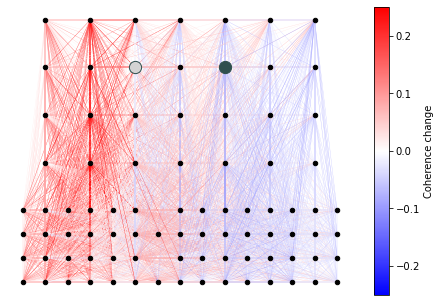

In [71]:
for session in ["MonkeyG_20150922_Session2_S1"]:
    print(session)

    laser_from = int(experiments[experiments['keyname'] == session]["stim_Coh_from"])
    laser_to = int(experiments[experiments['keyname'] == session]["stim_Coh_to"])
    sess1=first_data["high_gamma"][first_data["high_gamma"]["Experiment_block_key"]==session]#[data["high_gamma"]["Block_num"]==5]

    v_scale = .25

    sess1["prot_pred"] = res_protocol.predict(sess1)
    sess1["graph_pred"] = res_graph.predict(sess1)
    sess1["full_pred"] = res1.predict(sess1)

    sess1_copy = sess1[sess1["Distance"] < 10]

    # Build your graph
    G=nx.from_pandas_edgelist(sess1_copy, 'From_electrodes', 'To_electrodes', ['prot_pred', 'graph_pred', 'full_pred', 'End_diff'])

    M1 = get_M1_sites_from_experiment(session)
    node_colors = []
    for node in list(G.nodes):
        if node in M1:
            node_colors.append('darkgreen')
        else:
            node_colors.append('darkorange')
    
    nx.draw(G, with_labels=False, pos=locations,  node_color='black', node_size=20,
            edge_color=nx.to_pandas_edgelist(G)['End_diff'], width=.3, edge_cmap=plt.cm.bwr, edge_vmin = -v_scale, edge_vmax=v_scale)
    plt.scatter(locations[laser_from][0], locations[laser_from][1], color="darkslategrey", zorder=3, s=150)
    plt.scatter(locations[laser_to][0], locations[laser_to][1], color="lightgrey", edgecolor="darkslategrey", zorder=3, s=150)

    norm = plt.Normalize(vmin = -v_scale, vmax = v_scale)
#     lognorm = SymLogNorm(.000001, vmin=-v_scale, vmax=v_scale)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr, norm=norm)
    sm._A = []
    plt.colorbar(sm, label="Coherence change")

    plt.savefig("singlenetwork.pdf", dpi=100)
#     plt.axes().set_aspect('equal')
    plt.show()
    
#     figs.savefig("D:/gdrive/GDocuments/Nature_biomed/figures/presubfig_v2.pdf",bbox_inches='tight')
#     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150916_Session4_S1_preds_and_res6.pdf",bbox_inches='tight')
#     figs.savefig("/home/julien/lab/data/opto_data/figs/hgamma_MonkeyG_20150915_Session2_S1_preds_and_res6.pdf",bbox_inches='tight')

In [37]:
sess2

Initial_coh  Distance  Coh_proj  Coh_proj_sd     Phase  \
494626     0.747392  8.246211  0.261777     6.220647  0.007706   

        From_electrodes  To_electrodes  Initial_coh_sd  Coh_diff_sd  \
494626               20             36        0.060564     0.008331   

        Pair_avg_net_coh  ...  Is_stim_site_1  Is_stim_site_2  \
494626          0.856214  ...               1               1   

        Las1_distance_to_closer  Las1_distance_to_further  \
494626                      0.0                  8.246211   

        Las2_distance_to_closer  Las2_distance_to_further  Coh_diff_mag  \
494626                      0.0                  8.246211      0.079126   

        prot_pred  graph_pred full_pred  
494626  -0.013457   -0.167258 -0.168491  

[1 rows x 38 columns]